<a href="https://colab.research.google.com/github/DV2123/Various-Fine-Tunning-on-LLMs/blob/main/florence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q datasets flash_attn timm einops bitsandbytes accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 38.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 40.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.5/137.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have 

In [ ]:
from transformers import AutoProcessor, AutoModelForCausalLM
from PIL import Image, ImageDraw, ImageFont
import random
import numpy as np
colormap = ['blue','orange','green','purple','brown','pink','gray','olive','cyan','red',
            'lime','indigo','violet','aqua','magenta','coral','gold','tan','skyblue']
import requests
import copy
%matplotlib inline

In [ ]:
model_id = 'microsoft/Florence-2-large'

## HF Login

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

## Load model

In [ ]:
model = AutoModelForCausalLM.from_pretrained(model_id,
                                             trust_remote_code=True,
                                             device_map='cuda')
print(model)
processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True)

config.json:   0%|          | 0.00/2.44k [00:00<?, ?B/s]

configuration_florence2.py:   0%|          | 0.00/15.1k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-large:
- configuration_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_florence2.py:   0%|          | 0.00/127k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-large:
- modeling_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


pytorch_model.bin:   0%|          | 0.00/1.54G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/51.0 [00:00<?, ?B/s]

Florence2ForConditionalGeneration(
  (vision_tower): DaViT(
    (convs): ModuleList(
      (0): ConvEmbed(
        (proj): Conv2d(3, 256, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
        (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      )
      (1): ConvEmbed(
        (proj): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      )
      (2): ConvEmbed(
        (proj): Conv2d(512, 1024, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      )
      (3): ConvEmbed(
        (proj): Conv2d(1024, 2048, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      )
    )
    (blocks): ModuleList(
      (0): MySequential(
        (0): MySequential(
          (spatial_block): SpatialBlock(
            (conv1): PreNorm(
              (fn): De

preprocessor_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

processing_florence2.py:   0%|          | 0.00/46.4k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-large:
- processing_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


tokenizer_config.json:   0%|          | 0.00/34.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.10M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
def run_example(task_prompt, image):
    inputs = processor(text=task_prompt, images=image, return_tensors="pt")
    generated_ids = model.generate(
      input_ids=inputs["input_ids"].cuda(),
      pixel_values=inputs["pixel_values"].cuda(),
      max_new_tokens=1024,
      early_stopping=False,
      do_sample=False,
      num_beams=3,
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    parsed_answer = processor.post_process_generation(
        generated_text,
        task=task_prompt,
        image_size=(image.width, image.height)
    )

    return parsed_answer

In [ ]:
from PIL import Image

In [ ]:
local_image_path = "/content/x-ray chest report format - drlogy.jpg"

In [ ]:
image = Image.open(local_image_path)

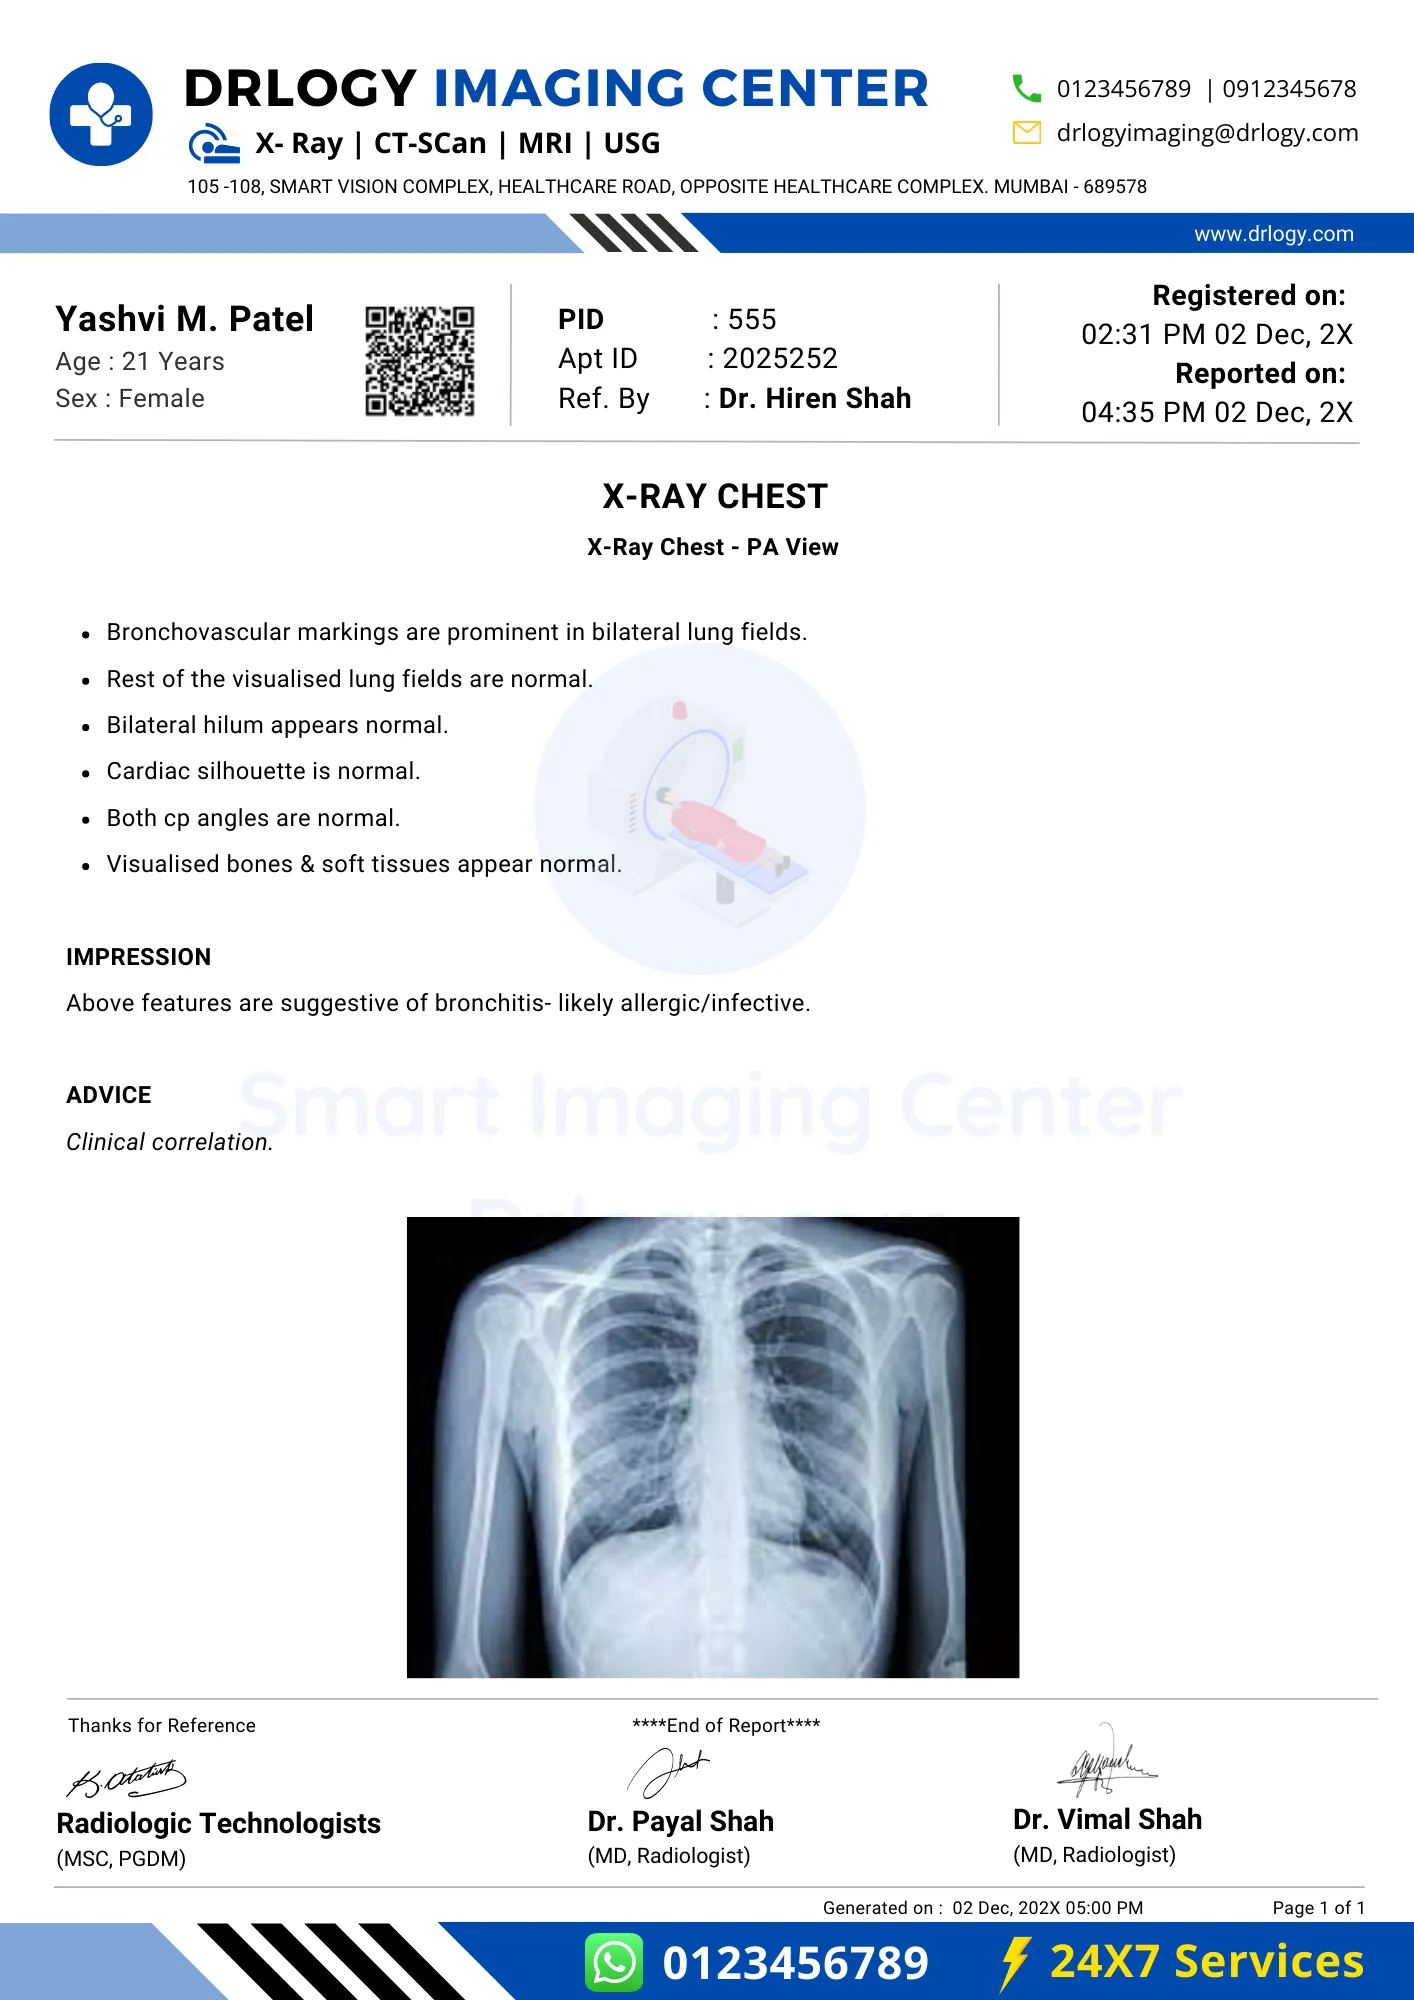

In [ ]:
image

## Caption Task

In [ ]:
task_prompt = '<CAPTION>'
run_example(task_prompt,image)

{'<CAPTION>': "x-ray chest x-ray image of a man's chest"}

## Detailed Caption

In [ ]:
task_prompt = '<DETAILED_CAPTION>'
run_example(task_prompt, image)

{'<DETAILED_CAPTION>': "The image shows a poster with an x-ray image of a man's chest, along with text, a barcode, and a QR code. The poster is likely advertising a radiology imaging center in Mumbai, as indicated by the text."}

#### To process the location tokens and render them on the image, the following method will be called to plot bounding boxes.

{'<OD>': {'bboxes': [[430.5630187988281, 1211.0, 973.5390014648438, 1685.0]], 'labels': ['person']}}


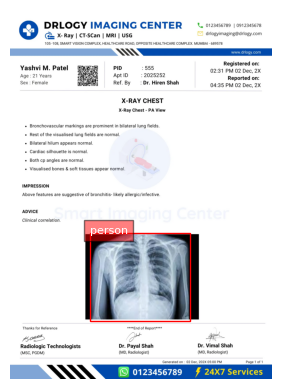

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
def plot_bbox(image, data):
   # Create a figure and axes
    fig, ax = plt.subplots()

    # Display the image
    ax.imshow(image)

    # Plot each bounding box
    for bbox, label in zip(data['bboxes'], data['labels']):
        # Unpack the bounding box coordinates
        x1, y1, x2, y2 = bbox
        # Create a Rectangle patch
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')
        # Add the rectangle to the Axes
        ax.add_patch(rect)
        # Annotate the label
        plt.text(x1, y1, label, color='white', fontsize=8, bbox=dict(facecolor='red', alpha=0.5))

    # Remove the axis ticks and labels
    ax.axis('off')

    # Show the plot
    plt.show()

task_prompt = '<OD>'
results = run_example(task_prompt,image)
print(results)
plot_bbox(image, results['<OD>'])

## OCR

This function processes Florence-2's output to get the location tokens, used them to draw bounding boxes, and then writes the label corresponding to the bounding boxes, i.e., the text recognized through OCR.

In [ ]:
def draw_ocr_bboxes(image, prediction):
    scale = 1
    draw = ImageDraw.Draw(image)
    bboxes, labels = prediction['quad_boxes'], prediction['labels']
    for box, label in zip(bboxes, labels):
        color = random.choice(colormap)
        new_box = (np.array(box) * scale).tolist()
        draw.polygon(new_box, width=3, outline=color)
        draw.text((new_box[0]+8, new_box[1]+2),
                    "{}".format(label),
                    align="right",

                    fill=color)
    display(image)

In [ ]:
task_prompt = '<OCR>'
run_example(task_prompt,image)

{'<OCR>': 'DRLOGY IMAGING CENTER0123456789 | 012345678X-Ray | CT-Scan | MRI | USGdrlogyimaging@drology.com105-108, SMART VISION COMPLEX, HEALTHCARE ROAD, OPPOSITE HEALTHCARECOMPLEX, MUMBAI - 669578www.drilogy.comYashvi M. PatelPIDRegistered on:Age : 21 YearsApt ID: 202525202:31 PM 02 Dec, 2XSex : FemaleRef. By: Dr. Hiren ShahReported on:04:35 PM 02 December, 2XX-RAY CHESTX-RAY Chest - PA ViewBronchovascular markings are prominent in bilateral lung fields.. Rest of the visualised lung fields are normal.Bilateral hilium appears normal.Cardiac silhouette is normal.Both cp angles are normal.. Visualised bones & soft tissues appear normal.IMPRESSIONAbove features are suggestive of bronchitis-likely allergic/infective.ADVICESmart Imaging CenterClinical correlation.**** End of Report ***Thanks for ReferenceRadiologic TechnologistsDr. Payal ShahDr. Vimal Shah(MSC, PGDM)(MD, Radiologist)Generated on : 02.02.2022 05:00 PMPage 1 of 1012345678924X7 Services'}

{'<OCR_WITH_REGION>': {'quad_boxes': [[181.69900512695312, 63.0, 933.947021484375, 63.0, 933.947021484375, 111.0, 181.69900512695312, 111.0], [1055.551025390625, 73.0, 1360.9749755859375, 73.0, 1360.9749755859375, 103.0, 1055.551025390625, 103.0], [250.98500061035156, 125.0, 663.8729858398438, 125.0, 663.8729858398438, 159.0, 250.98500061035156, 159.0], [1055.551025390625, 119.0, 1362.3890380859375, 119.0, 1362.3890380859375, 149.0, 1055.551025390625, 149.0], [187.35501098632812, 173.0, 1150.2890625, 173.0, 1150.2890625, 197.0, 187.35501098632812, 197.0], [1192.708984375, 223.0, 1356.7330322265625, 223.0, 1356.7330322265625, 247.0, 1192.708984375, 247.0], [53.025001525878906, 299.0, 318.85699462890625, 299.0, 318.85699462890625, 335.0, 53.025001525878906, 335.0], [557.822998046875, 305.0, 605.8989868164062, 305.0, 605.8989868164062, 331.0, 557.822998046875, 331.0], [711.9490356445312, 305.0, 778.4070434570312, 305.0, 778.4070434570312, 331.0, 711.9490356445312, 331.0], [1150.2890625, 2

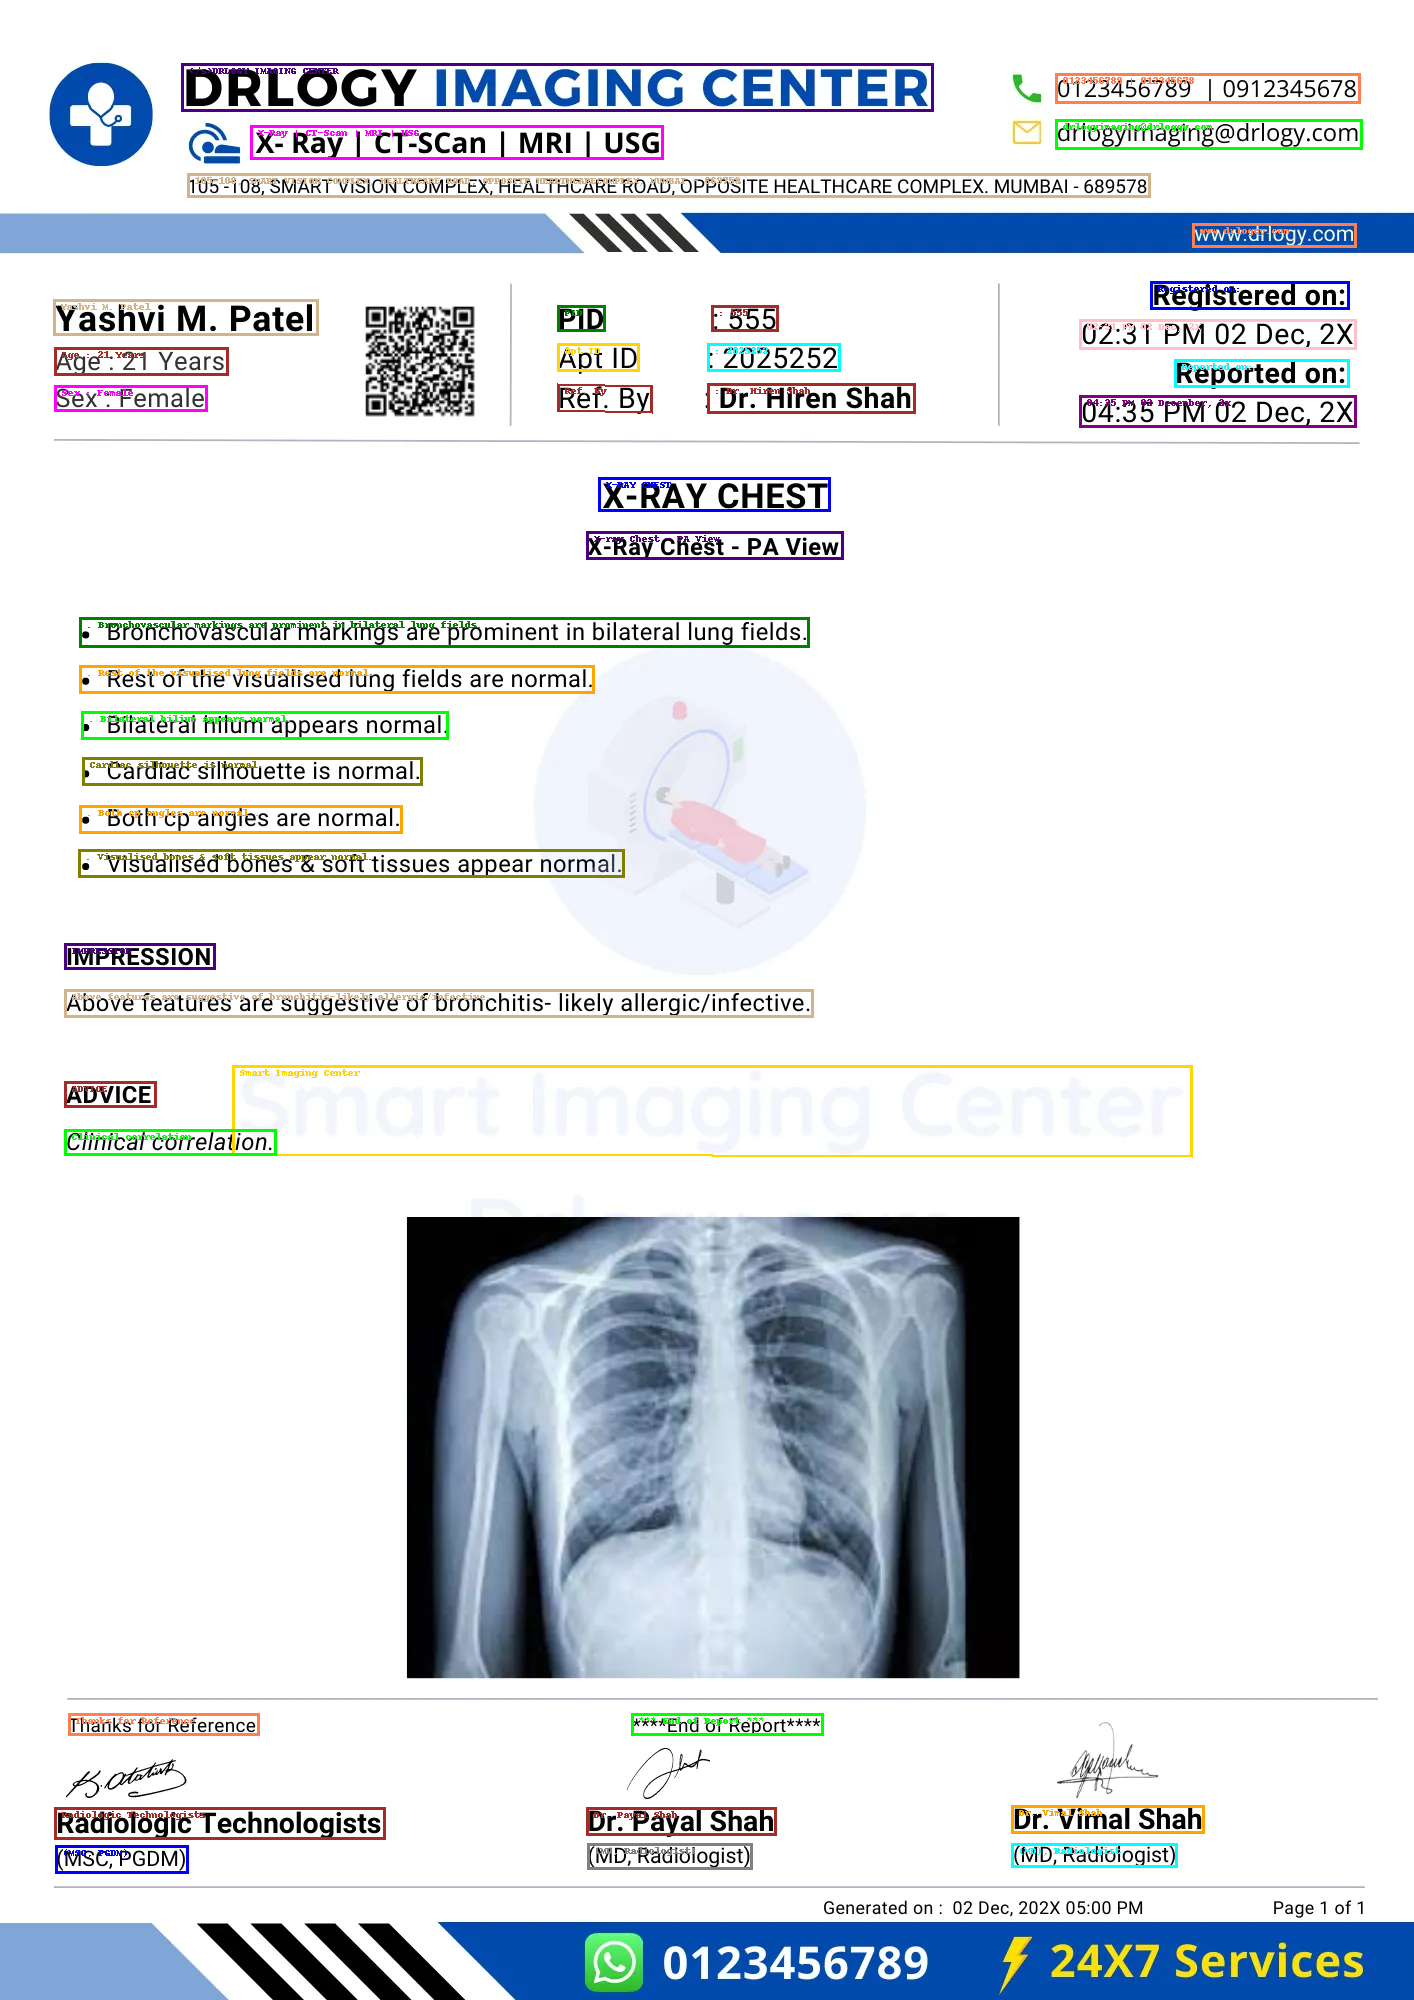

In [ ]:
task_prompt = '<OCR_WITH_REGION>'
results = run_example(task_prompt,image)
print(results)
output_image = copy.deepcopy(image)
draw_ocr_bboxes(output_image, results['<OCR_WITH_REGION>'])

## Fine Tuning

In [ ]:
import torch
from PIL import Image
from datasets import load_dataset
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModelForCausalLM, AutoProcessor, get_scheduler
from tqdm import tqdm
import numpy as np
from bitsandbytes.optim import AdamW

In [ ]:
model.gradient_checkpointing_enable(gradient_checkpointing_kwargs={'use_reentrant':True})
for param in model.vision_tower.parameters():
  param.is_trainable = False

In [ ]:
data = load_dataset("derek-thomas/ScienceQA")

Generating train split:   0%|          | 0/12726 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/4241 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/4241 [00:00<?, ? examples/s]

In [ ]:
class MMInstructDataset(Dataset):

    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        example = self.data[idx]
        question = "<MMCHAT>"+example['question']+"\n\nAnswer:\n"
        choices = example['choices']
        answer = example['choices'][int(example['answer'])]
        if example['image'] is not None:
          image = example['image'].convert("RGB")
        else:
          zz = np.random.rand(50,50)
          image = Image.fromarray(zz).convert("RGB")
        return question, answer, image

In [ ]:
def collate_fn(batch):
    questions, answers, images = zip(*batch)
    inputs = processor(text=list(questions), images=list(images), return_tensors="pt", padding=True).to("cuda")
    return inputs, answers

In [ ]:
train_dataset = MMInstructDataset(data['train'])
val_dataset = MMInstructDataset(data['validation'])

batch_size = 1
gradient_accumulation_steps = 8
num_workers = 0

train_loader = DataLoader(train_dataset, batch_size=batch_size,
                          collate_fn=collate_fn, num_workers=num_workers, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size,
                          collate_fn=collate_fn, num_workers=num_workers)

In [ ]:
optimizer = AdamW(model.parameters(), lr=1e-6, optim_bits = 8, is_paged=True)

epochs = 2
num_training_steps = epochs * len(train_loader)

lr_scheduler = get_scheduler(name="linear", optimizer=optimizer,
                              num_warmup_steps=0, num_training_steps=num_training_steps,)

for epoch in range(epochs):
    model.train()
    train_loss = 0
    i = -1
    for inputs, answers in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}/{epochs}"):
        i += 1
        input_ids = inputs["input_ids"]
        pixel_values = inputs["pixel_values"]
        labels = processor.tokenizer(text=answers, return_tensors="pt", padding=True, return_token_type_ids=False).input_ids.to("cuda")
        outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=labels)
        loss = outputs.loss/gradient_accumulation_steps
        loss.backward()
        if i % gradient_accumulation_steps == 0:
          optimizer.step()
          lr_scheduler.step()
          optimizer.zero_grad()
          train_loss += loss.item()
    avg_train_loss = train_loss / len(train_loader)
    print(f"Average Training Loss: {avg_train_loss}")

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Validation Epoch {epoch + 1}/{epochs}"):
            inputs, answers = batch
            input_ids = inputs["input_ids"]
            pixel_values = inputs["pixel_values"]
            labels = processor.tokenizer(text=answers, return_tensors="pt", padding=True, return_token_type_ids=False).input_ids.to("cuda")
            outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=labels)
            loss = outputs.loss
            val_loss += loss.item()

        print(val_loss / len(val_loader))

Training Epoch 1/2:   0%|          | 0/12726 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]
Training Epoch 1/2:   1%|          | 158/12726 [04:51<6:20:20,  1.82s/it]

In [ ]:
model.save_pretrained("./florence_multimodal_finetuned/")